In [1]:
import torch 
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, datasets
from torchvision.io import read_image
import matplotlib.pyplot as plt
from model import Unet
from train import sample

/home/khw5218/miniconda3/envs/diffusion/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
image_size = 28
channels = 3
timesteps = 200
# sample: (timestamps, 3, img size, img size)

In [3]:
device = torch.device("cuda")

In [4]:
model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model = nn.DataParallel(model)
check_point = torch.load("./checkpoint_scratch/step1200_model.tar")
model.load_state_dict(check_point['model_state_dict'])


<All keys matched successfully>

In [5]:
model.to("cuda")

DataParallel(
  (module): Unet(
    (init_conv): Conv2d(3, 18, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (time_mlp): Sequential(
      (0): SinusoidalPositionEmbeddings()
      (1): Linear(in_features=28, out_features=112, bias=True)
      (2): GELU(approximate='none')
      (3): Linear(in_features=112, out_features=112, bias=True)
    )
    (downs): ModuleList(
      (0): ModuleList(
        (0): ConvNextBlock(
          (mlp): Sequential(
            (0): GELU(approximate='none')
            (1): Linear(in_features=112, out_features=18, bias=True)
          )
          (ds_conv): Conv2d(18, 18, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=18)
          (net): Sequential(
            (0): GroupNorm(1, 18, eps=1e-05, affine=True)
            (1): Conv2d(18, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): GELU(approximate='none')
            (3): GroupNorm(1, 56, eps=1e-05, affine=True)
            (4): Conv2d(56, 28, kernel_size=(3, 3),

In [6]:
samples = sample(model, image_size=image_size, batch_size=64, channels=channels)

sampling loop time step: 100%|██████████| 200/200 [01:04<00:00,  3.11it/s]


In [8]:
samples.shape

torch.Size([200, 64, 3, 28, 28])

torch.Size([200, 3, 28, 28]) tensor(-3.5462) tensor(3.7427)


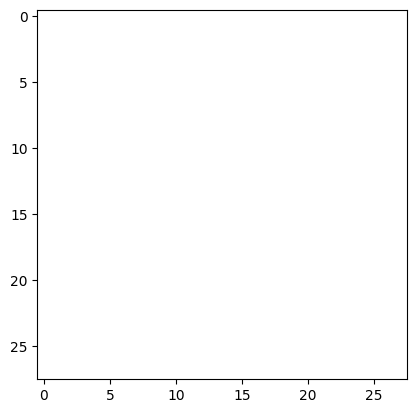

In [27]:
import matplotlib.animation as animation
%matplotlib inline

random_index = 1
images = samples[:, random_index, ...].squeeze()
# images = (images - images.min()) / (images.max() - images.min())
print(images.size(), images.min(), images.max())
fig, ax = plt.subplots()
ims = []
for i in range(timesteps):
    tmp = images[i]
    tmp = (tmp - tmp.min()) / (tmp.max() - tmp.min())
    im = ax.imshow(tmp.permute(1, 2, 0), animated=True)
    ims.append([im])
animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
animate.save('diffusion_{:0>2}.gif'.format(random_index), writer="pillow")

In [20]:
import matplotlib.animation as animation

random_index = 53

fig = plt.figure()
ims = []
for i in range(timesteps):
    im = plt.imshow(sample[i].reshape(image_size, image_size, channels), animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
animate.save('diffusion.gif')
plt.show()

RuntimeError: shape '[28, 28, 3]' is invalid for input of size 181984

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.imshow(sample.reshape(image_size, image_size, channels), cmap="gray")

In [6]:
t = torch.tensor([[1,2,3,4]])
print(t.size())

t = torch.squeeze(t)
print(t.size())

torch.Size([1, 4])
torch.Size([4])


In [12]:
t = torch.randn((20, 4, 3, 28, 28))
print(t.size())
idx = torch.tensor([0])
image = torch.index_select(t, 1, idx).squeeze()
print(image.size())

torch.Size([20, 4, 3, 28, 28])
torch.Size([20, 3, 28, 28])


In [14]:
writer = SummaryWriter()

In [15]:
x = torch.arange(-5, 5, 0.1).view(-1, 1)
y = -5 * x + 0.1 * torch.randn(x.size())

model = torch.nn.Linear(1, 1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

def train_model(iter):
    for epoch in range(iter):
        y1 = model(x)
        loss = criterion(y1, y)
        writer.add_scalar("Loss/train", loss, epoch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

train_model(10)
writer.flush()

In [17]:
!tensorboard --logdir=runs --port=6009

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.15.1 at http://localhost:6009/ (Press CTRL+C to quit)
^C


In [13]:
init_dim = 16
dim = 32
dim_mults = (1,2,4,8)
dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
print(dims)
in_out = list(zip(dims[:-1], dims[1:]))
print(in_out)

print(dims[:-1])
print(dims[1:])

[16, 32, 64, 128, 256]
[(16, 32), (32, 64), (64, 128), (128, 256)]
[16, 32, 64, 128]
[32, 64, 128, 256]
